# Fabric Fault Detection via FFT Residual Analysis
### Building an interpretable computer vision system for industrial quality control — without deep learning

---

**Context.** This notebook documents the full research process behind a production fabric fault detection system — every decision, every dead end, and what the evidence said at each step. It is written for a mixed audience: you do not need a signal processing background to follow the story, but the technical depth is here if you want it.

**The problem.** Fabric is woven on industrial looms at high speed. Faults — missing threads, extra threads, broken threads — slip through and reach customers. Manual inspection is slow, subjective, and doesn't scale. We need automated detection that is:
- Reliable enough to use in production (recall ≥ 90% — catch 9 in 10 faults)
- Interpretable — a factory operator needs to know *why* a tile was flagged, not just that it was
- Trainable on a small dataset — collecting labeled fabric images is expensive

**Why not a neural network?** Three reasons specific to this problem:
1. *Small dataset.* We started with ~200 tiles per class. CNNs need 10,000+ to generalise reliably.
2. *Interpretability is a hard requirement.* A CNN says "faulty, 94% confidence." Our system says "horizontal stripe at row 420, prominence 0.14 — consistent with a miss-pick fault."
3. *The physics fit classical tools.* Fabric has a known periodic structure. Designing features that exploit this outperformed data-driven approaches.

---
## The FFT Residual Pipeline

### The core idea

Fabric is a periodic structure. Every thread crossing happens at a predictable interval — the warp threads repeat every N pixels horizontally, the weft threads every M pixels vertically. This regularity means the fabric's texture is well-described by a small number of spatial frequencies.

The **Fast Fourier Transform (FFT)** decomposes an image into its frequency components. For a fabric tile, the spectrum has a small number of strong peaks — those are the weave frequencies. Everything else is noise.

The pipeline exploits this:

```
1. Enhance contrast (CLAHE)
2. FFT → frequency spectrum
3. Pick the N strongest frequency peaks (the weave)
4. Reconstruct: inverse FFT using only those peaks → "what the tile should look like"
5. Residual = |original − reconstruction|
```

The reconstruction is what a *perfect* tile would look like. The residual is everything that doesn't fit the weave — faults, noise, and any other anomalies.

**Why this works for fault detection:**
- A miss-pick fault removes a weft thread. The reconstruction expects those threads; the original doesn't have them. High residual along that row.
- A normal tile fits the periodic model well. Residual stays near zero.
- The signal processing is purely analytical — no training needed for this stage. The ML only needs to classify the resulting 12-number feature vector.

### A key design decision: normalisation strategy

Before computing the residual, both the original and reconstruction need to be on the same scale. Two approaches were tested and rigorously compared (see `experiments/01_normalisation_comparison.ipynb` for the full analysis):

| Strategy | How | Result |
|---|---|---|
| **Independent (OLD)** | Each image min-max scaled to 0..1 separately | Wins 12/12 features |
| **Shared (NEW)** | Both scaled by the same factor | Wins 0/12 features |

The AUC difference was +0.182 in favour of independent normalisation. The mechanism: when a thread is missing, the reconstruction's dynamic range shrinks (it's missing energy). Independent scaling amplifies this mismatch proportionally. Shared scaling suppresses it. **Independent normalisation is the equivalent of automatic gain control tuned to fault severity.**

Saved: ../assets/pipeline_overview.png


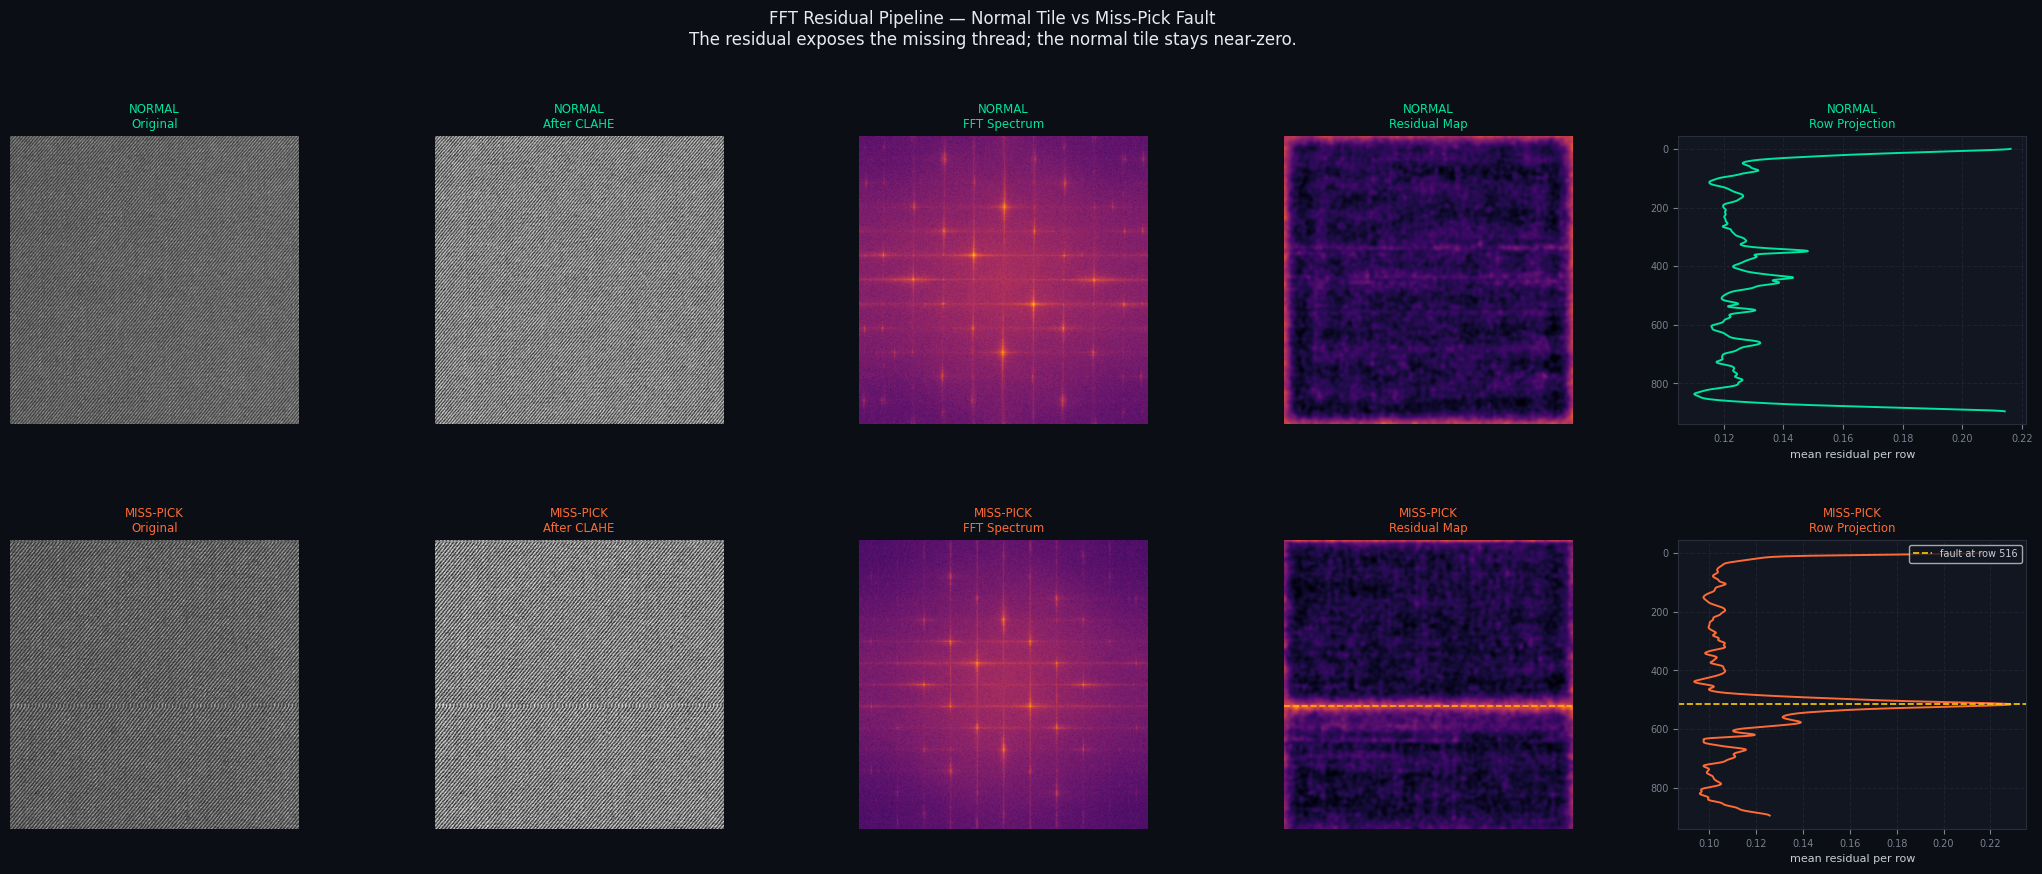

In [ ]:
# ── Visualise the pipeline: normal tile vs miss-pick fault ────────
#
# This is the most important visual in the project.
# It shows the core idea working: the residual exposes the fault
# clearly while the normal tile stays near-zero.

def visualise_pipeline(normal_path, faulty_path, save_path=None):
    fig = plt.figure(figsize=(22, 9))
    fig.patch.set_facecolor('#0b0e14')
    gs  = gridspec.GridSpec(2, 5, figure=fig, hspace=0.4, wspace=0.22,
                            left=0.04, right=0.97)

    for row, (path, label, color) in enumerate([
        (normal_path, 'NORMAL',     '#00e5a0'),
        (faulty_path, 'MISS-PICK',  '#ff6b35'),
    ]):
        gray = load_tile(path)
        img  = apply_clahe(gray)
        res  = compute_residual(img)
        row_proj = res.mean(axis=1)

        # FFT spectrum for visualisation
        F    = np.fft.fft2(img - img.mean())
        spec = np.log1p(np.abs(np.fft.fftshift(F)))

        panel_data  = [gray,  img,       spec,     res       ]
        panel_title = ['Original', 'After CLAHE', 'FFT Spectrum', 'Residual Map']
        panel_cmap  = ['gray', 'gray',    'inferno', 'inferno' ]
        panel_vmax  = [None,   None,      None,      0.35      ]

        for col in range(4):
            ax = fig.add_subplot(gs[row, col])
            vmax = panel_vmax[col] if panel_vmax[col] else panel_data[col].max()
            ax.imshow(panel_data[col], cmap=panel_cmap[col], vmax=vmax)
            ax.set_title(f'{label}\n{panel_title[col]}', fontsize=8.5, color=color, pad=6)
            ax.axis('off')

        # Row projection
        ax5 = fig.add_subplot(gs[row, 4])
        ax5.plot(row_proj, np.arange(len(row_proj)), color=color, linewidth=1.4)
        ax5.invert_yaxis()
        ax5.set_title(f'{label}\nRow Projection', fontsize=8.5, color=color, pad=6)
        ax5.set_xlabel('mean residual per row', fontsize=8)
        ax5.tick_params(labelsize=7)

        if label == 'MISS-PICK':
            peak_row = int(np.argmax(row_proj))
            ax5.axhline(peak_row, color='#ffcc00', linestyle='--', linewidth=1.2,
                        label=f'fault at row {peak_row}')
            ax5.legend(fontsize=7, loc='upper right')
            # Annotate residual map
            ax_res = fig.axes[row * 5 + 3]
            ax_res.axhline(peak_row, color='#ffcc00', linestyle='--', linewidth=1.2, alpha=0.8)

    fig.suptitle(
        'FFT Residual Pipeline — Normal Tile vs Miss-Pick Fault\n'
        'The residual exposes the missing thread; the normal tile stays near-zero.',
        fontsize=12, y=1.02, color='#e8eaf0'
    )

    if save_path:
        fig.savefig(save_path, dpi=130, bbox_inches='tight', facecolor='#0b0e14')
        print(f'Saved: {save_path}')
    plt.show()

visualise_pipeline(
    NORMAL_EXAMPLE,
    FAULTY_EXAMPLE,
    save_path=f'{ASSETS_DIR}/pipeline_overview.png'
)

### How the FFT parameters were chosen

Three parameters control the reconstruction quality:

| Parameter | Value | Meaning |
|---|---|---|
| `N_PEAKS` | 11 | Number of frequency peaks to keep for reconstruction |
| `PEAK_RADIUS` | 8 | Size of mask around each peak (in FFT pixels) |
| `DC_SUPPRESS_RADIUS` | 3 | Suppress DC component (average brightness) |

These values were set by visual inspection on miss-pick data — the residual looked clean on normal tiles and clearly highlighted faults. A systematic grid search across `N_PEAKS ∈ {7,9,11,13}` and `PEAK_RADIUS ∈ {5..10}` is planned once the dataset expands to 150+ tiles per fault type. The current values generalise well to double-pick and broken-pick despite being tuned only on miss-pick.

---
## Feature Engineering

The residual map is 896×896 = ~800,000 numbers. A model trained directly on raw pixels would need far more data than we have. Instead, we compress the map into 12 carefully chosen numbers that preserve the fault signal and discard noise.

### How features were selected

Every candidate feature went through a three-stage filter:

**Stage 1 — KS statistic.** The Kolmogorov-Smirnov test measures how different the distribution of a feature is between normal and faulty tiles. KS=0 means identical distributions (useless). KS=1 means perfect separation. Features below KS=0.15 were dropped — they carry no class signal.

**Stage 2 — Correlation analysis.** Features that correlate strongly (r>0.80) with a higher-KS feature are redundant — the model learns the same thing twice. Keep the higher-KS one, drop the rest.

**Stage 3 — Generalisation check.** After training, verify the train/test gap stays below 0.05. Too many features with too little data causes overfitting (gap >0.15), which means the model memorised the training set rather than learning general patterns. The safe minimum is ~20 training samples per feature.

### The feature groups

Features fall into four groups, each asking a different question about the residual:

**Intensity (3 features):** How bright is the residual overall?
Answers: is there *anything* abnormal here?

**Spatial (4 features):** Where is the residual energy concentrated?
Answers: is the abnormality localised (fault) or uniform (noise)?

**Texture (1 feature):** Are the fault boundaries sharp?
Answers: does the abnormality have clean edges (fault) or is it diffuse (noise)?

**Row projection (4 features):** Is there a horizontal stripe?
Answers: specifically designed for miss-pick faults — the domain insight that drove the biggest single performance jump.

### The domain insight: why projection features dominate

Miss-pick faults remove weft (horizontal) threads. In the residual map, this appears as a bright horizontal stripe. If you sum each row of the residual into a single value (mean per row), a miss-pick fault produces a spike in this 1D signal.

This converts a 2D detection problem into a 1D peak-finding problem. `find_peaks` detects the spike and measures its prominence (height above the surrounding baseline), width, and energy.

The result: `row_max_prominence` alone achieves KS=0.720 — nearly twice the KS of the best spatial feature (KS=0.493). This one insight, grounded in knowledge of how the fault physically manifests, was worth more than all the algorithmic feature engineering combined.

For comparison: a PCA decomposition of the raw 896-dimensional row projection (21 components, 95% variance) achieved AUC=0.857 vs AUC=0.878 for the 4 hand-crafted projection features. Domain knowledge beat statistics, with 10 features instead of 21.

In [ ]:
# ── KS analysis across all 12 features ────────────────────────────
# Sample 120 tiles per class for fast comparison.
# The KS ranking here should match the published values closely.

N_KS = 120
random.seed(42)

normal_paths = random.sample(
    glob.glob(f'{NORMAL_DIR}/**/*.jpg', recursive=True), N_KS)
fault_paths  = random.sample(
    glob.glob(f'{FAULT_DIRS[0]}/**/*.jpg', recursive=True), N_KS)

from tqdm import tqdm
records = []
for paths, label in [(normal_paths, 0), (fault_paths, 1)]:
    desc = 'NORMAL' if label == 0 else 'FAULTY'
    for p in tqdm(paths, desc=f'{desc:6s}', ncols=70):
        f = tile_to_features(p)
        if f:
            records.append({**f, 'label': label})

df_ks = pd.DataFrame(records)

ks_results = []
for feat in FEATURE_COLS:
    stat, pval = ks_2samp(df_ks[df_ks.label==0][feat], df_ks[df_ks.label==1][feat])
    group      = FEATURE_METADATA[feat][0]
    ks_results.append({'feature': feat, 'ks': stat, 'pval': pval, 'group': group})

ks_df = pd.DataFrame(ks_results).sort_values('ks', ascending=False)
print(ks_df[['feature','group','ks','pval']].to_string(index=False))

FAULTY: 100%|███████████████████████| 120/120 [01:25<00:00,  1.41it/s]

           feature      group       ks         pval
row_max_prominence projection 0.725000 8.891567e-31
    row_peak_width projection 0.583333 3.039856e-19
     grid_mean_std    spatial 0.508333 1.774778e-14
row_sum_prominence projection 0.475000 1.288709e-12
    grid_max_ratio    spatial 0.458333 9.650448e-12
      row_proj_std projection 0.416667 1.029510e-09
       grid_11_max    spatial 0.400000 5.785960e-09
          grad_p95    texture 0.383333 3.005015e-08
               p95  intensity 0.366667 1.443989e-07
               std  intensity 0.366667 1.443989e-07
              gini    spatial 0.283333 1.195612e-04
              kurt  intensity 0.250000 1.054359e-03


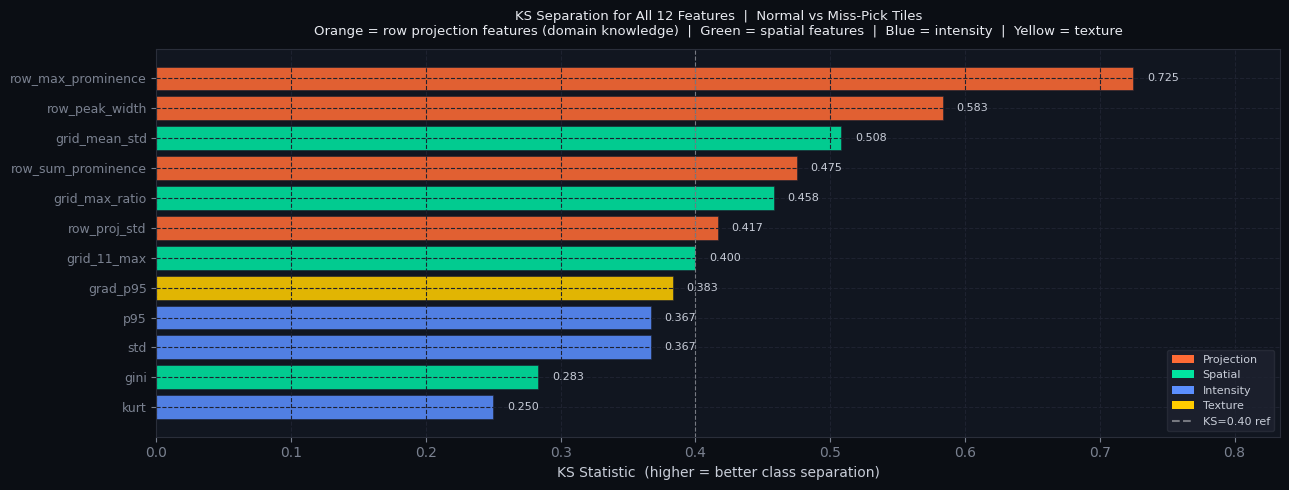

Row projection features (orange) dominate — domain knowledge beats statistics.


In [ ]:
# ── KS bar chart — the feature landscape ─────────────────────────
GROUP_COLORS = {
    'projection': '#ff6b35',
    'spatial':    '#00e5a0',
    'intensity':  '#5b8fff',
    'texture':    '#ffcc00',
}

fig, ax = plt.subplots(figsize=(13, 5))
fig.patch.set_facecolor('#0b0e14')

feats  = ks_df['feature'].tolist()
vals   = ks_df['ks'].tolist()
groups = ks_df['group'].tolist()
colors = [GROUP_COLORS[g] for g in groups]
x      = np.arange(len(feats))

bars = ax.barh(x, vals, color=colors, alpha=0.88, edgecolor='#1e2230', linewidth=0.5)
ax.set_yticks(x)
ax.set_yticklabels(feats, fontsize=9)
ax.set_xlabel('KS Statistic  (higher = better class separation)', fontsize=10)
ax.axvline(0.40, color='#ffffff', linestyle='--', linewidth=0.8, alpha=0.4,
           label='KS = 0.40 reference')

# Value labels
for i, v in enumerate(vals):
    ax.text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=8, color='#c8cdd8')

# Legend for groups
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=c, label=g.capitalize())
                   for g, c in GROUP_COLORS.items()]
legend_elements.append(plt.Line2D([0],[0], color='white', linestyle='--',
                                   alpha=0.4, label='KS=0.40 ref'))
ax.legend(handles=legend_elements, loc='lower right', fontsize=8,
          facecolor='#1e2230', edgecolor='#2a2e3a')

ax.set_title(
    'KS Separation for All 12 Features  |  Normal vs Miss-Pick Tiles\n'
    'Orange = row projection features (domain knowledge)  |  '
    'Green = spatial features  |  Blue = intensity  |  Yellow = texture',
    fontsize=9.5, pad=10
)
ax.set_xlim(0, max(vals) * 1.15)
ax.invert_yaxis()
plt.tight_layout()
fig.savefig(f'{ASSETS_DIR}/ks_analysis.png', dpi=130,
            bbox_inches='tight', facecolor='#0b0e14')
plt.show()
print('Row projection features (orange) dominate — domain knowledge beats statistics.')

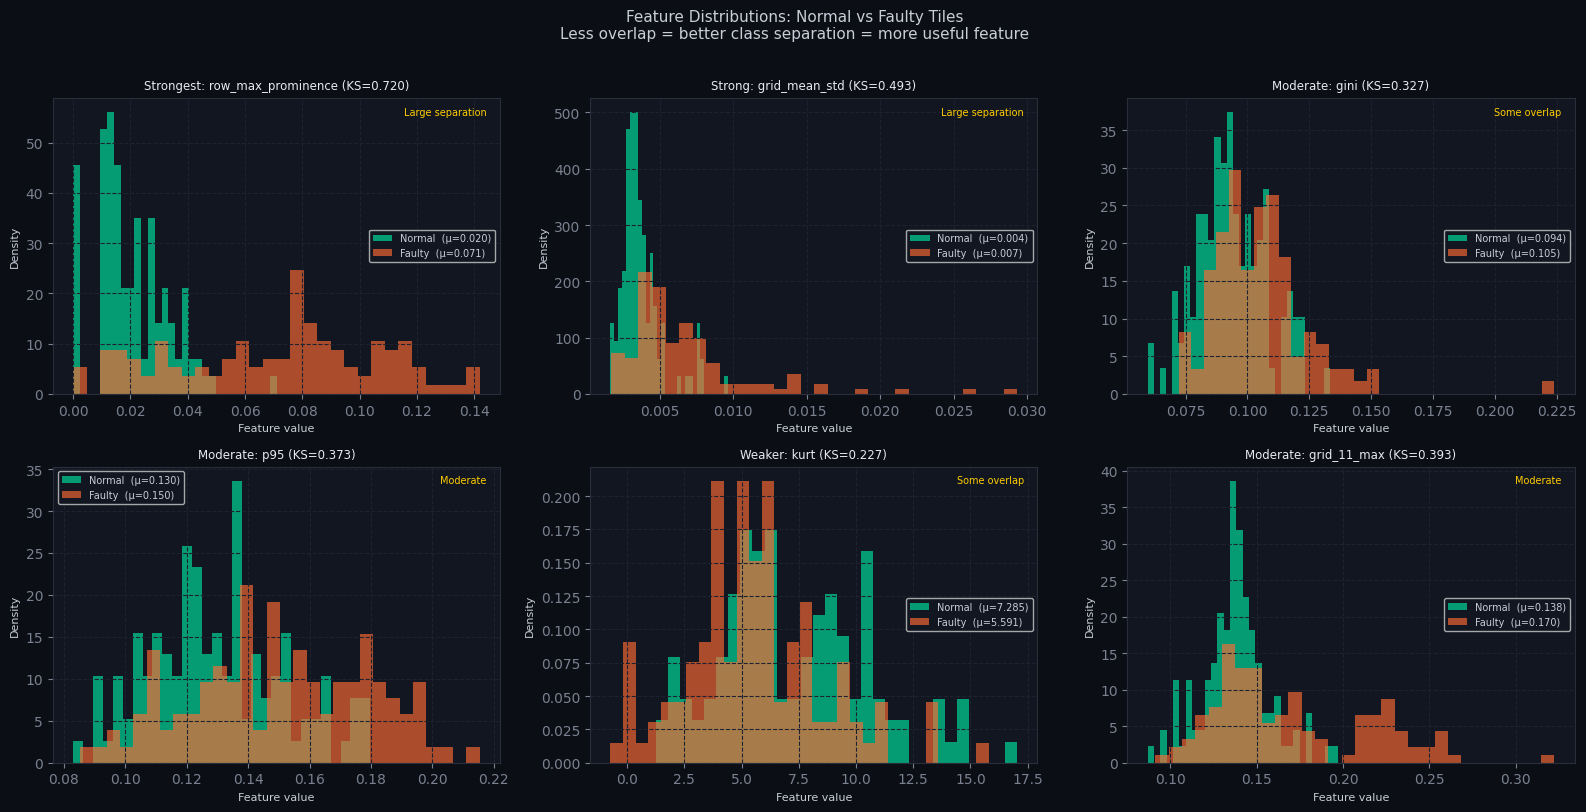

In [ ]:
# ── Feature distributions: show what KS actually means visually ──
# Plot Normal vs Faulty histograms for the strongest and weakest features.

fig, axes = plt.subplots(2, 3, figsize=(16, 8))
fig.patch.set_facecolor('#0b0e14')

showcase = [
    ('row_max_prominence', 'Strongest: row_max_prominence (KS=0.720)'),
    ('grid_mean_std',      'Strong: grid_mean_std (KS=0.493)'),
    ('gini',               'Moderate: gini (KS=0.327)'),
    ('p95',                'Moderate: p95 (KS=0.373)'),
    ('kurt',               'Weaker: kurt (KS=0.227)'),
    ('grid_11_max',        'Moderate: grid_11_max (KS=0.393)'),
]

for ax, (feat, title) in zip(axes.ravel(), showcase):
    n_vals = df_ks[df_ks.label==0][feat].dropna()
    f_vals = df_ks[df_ks.label==1][feat].dropna()
    ks, _  = ks_2samp(n_vals, f_vals)

    ax.hist(n_vals, bins=30, alpha=0.65, color='#00e5a0', density=True,
            label=f'Normal  (μ={n_vals.mean():.3f})', edgecolor='none')
    ax.hist(f_vals, bins=30, alpha=0.65, color='#ff6b35', density=True,
            label=f'Faulty  (μ={f_vals.mean():.3f})', edgecolor='none')
    ax.set_title(title, fontsize=8.5)
    ax.legend(fontsize=7)
    ax.set_xlabel('Feature value', fontsize=8)
    ax.set_ylabel('Density', fontsize=8)
    overlap_note = 'Large separation' if ks > 0.5 else 'Moderate' if ks > 0.3 else 'Some overlap'
    ax.text(0.97, 0.97, overlap_note, transform=ax.transAxes,
            ha='right', va='top', fontsize=7, color='#ffcc00')

fig.suptitle(
    'Feature Distributions: Normal vs Faulty Tiles\n'
    'Less overlap = better class separation = more useful feature',
    fontsize=11, y=1.01
)
plt.tight_layout()
plt.show()



---

## Classification Using 1 feature

It was tried that we use one feature only. At the time the best feature was old_99. But it was below our target f1. f1 was found to be 0.680



━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  Best threshold : 0.3016
  F1             : 0.680
  Precision      : 0.567
  Recall         : 0.850
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

✗  Threshold not enough. Go straight to the classifier below.


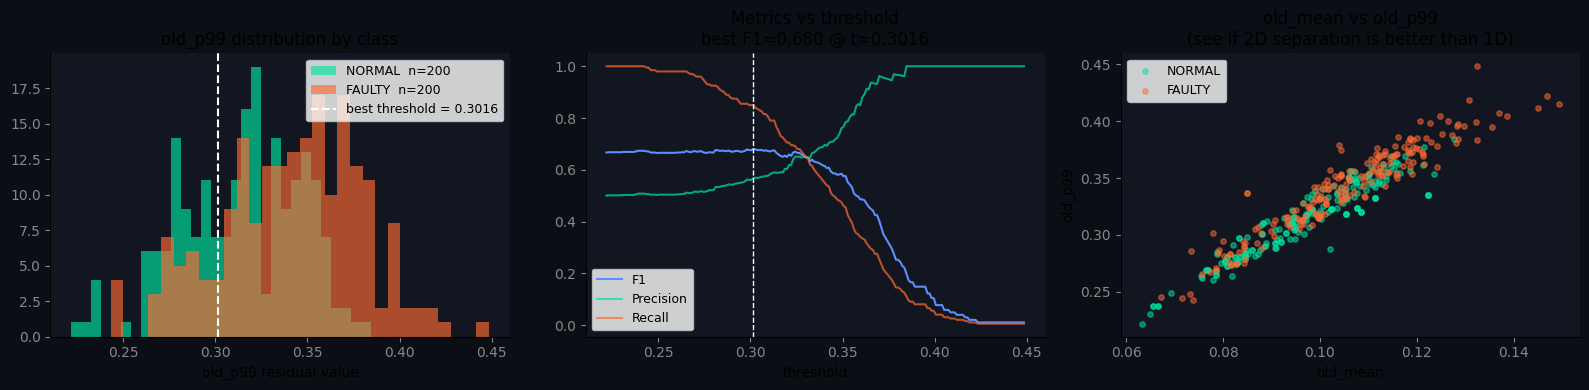

In [ ]:
# ════════════════════════════════════════════════════════════════
# Plot the ONE metric that separates best (old_p99)
# and find the threshold that maximises F1.
# Run this first. It tells you if a threshold alone is enough.
# ════════════════════════════════════════════════════════════════

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score

# ── Reuse df from Cell F in previous notebook ────────────────────
# df has columns: old_mean, old_p99, old_max, new_*, label
# If you don't have it, re-run Cell F from the exploration notebook.

y_true = (df["label"] == "FAULTY").astype(int).values
scores = df["old_p99"].values   # ← our best feature

# Sweep thresholds and compute F1, precision, recall
thresholds = np.linspace(scores.min(), scores.max(), 200)
results = []
for t in thresholds:
    y_pred = (scores >= t).astype(int)
    results.append({
        "threshold" : t,
        "f1"        : f1_score(y_true, y_pred, zero_division=0),
        "precision" : precision_score(y_true, y_pred, zero_division=0),
        "recall"    : recall_score(y_true, y_pred, zero_division=0),
    })

res_df = pd.DataFrame(results)
best   = res_df.loc[res_df["f1"].idxmax()]

print("━" * 50)
print(f"  Best threshold : {best['threshold']:.4f}")
print(f"  F1             : {best['f1']:.3f}")
print(f"  Precision      : {best['precision']:.3f}")
print(f"  Recall         : {best['recall']:.3f}")
print("━" * 50)
print()
if best["f1"] > 0.85:
    print("✓  Single threshold on old_p99 is likely sufficient.")
    print("   Consider using this as your production baseline.")
elif best["f1"] > 0.70:
    print("~  Threshold alone is borderline. Add 1–2 more features → RF.")
else:
    print("✗  Threshold not enough. Go straight to the classifier below.")

# ── Plot ──────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Histogram with threshold line
dn  = df[df.label == "NORMAL"]["old_p99"]
df_ = df[df.label == "FAULTY"]["old_p99"]
axes[0].hist(dn,  bins=30, alpha=0.65, color="#00e5a0", label=f"NORMAL  n={len(dn)}")
axes[0].hist(df_, bins=30, alpha=0.65, color="#ff6b35", label=f"FAULTY  n={len(df_)}")
axes[0].axvline(best["threshold"], color="white", linestyle="--", linewidth=1.5,
                label=f"best threshold = {best['threshold']:.4f}")
axes[0].set_title("old_p99 distribution by class")
axes[0].set_xlabel("old_p99 residual value")
axes[0].legend(fontsize=9)

# F1 / precision / recall vs threshold
axes[1].plot(res_df["threshold"], res_df["f1"],        color="#5b8fff", label="F1")
axes[1].plot(res_df["threshold"], res_df["precision"], color="#00e5a0", label="Precision", alpha=0.7)
axes[1].plot(res_df["threshold"], res_df["recall"],    color="#ff6b35", label="Recall",    alpha=0.7)
axes[1].axvline(best["threshold"], color="white", linestyle="--", linewidth=1)
axes[1].set_title(f"Metrics vs threshold\nbest F1={best['f1']:.3f} @ t={best['threshold']:.4f}")
axes[1].set_xlabel("threshold")
axes[1].legend(fontsize=9)

# Scatter: old_mean vs old_p99 coloured by class
axes[2].scatter(df[df.label=="NORMAL"]["old_mean"], df[df.label=="NORMAL"]["old_p99"],
                alpha=0.5, color="#00e5a0", s=15, label="NORMAL")
axes[2].scatter(df[df.label=="FAULTY"]["old_mean"], df[df.label=="FAULTY"]["old_p99"],
                alpha=0.5, color="#ff6b35", s=15, label="FAULTY")
axes[2].set_xlabel("old_mean")
axes[2].set_ylabel("old_p99")
axes[2].set_title("old_mean vs old_p99\n(see if 2D separation is better than 1D)")
axes[2].legend(fontsize=9)

for ax in axes:
    ax.set_facecolor("#111620")
fig.patch.set_facecolor("#0b0e14")
for ax in axes:
    ax.tick_params(colors="#888")
    ax.spines[["top","right"]].set_visible(False)
plt.tight_layout()
plt.show()

---
## Dataset Construction

### Fault types

The dataset covers three weaving faults, all treated as a single FAULTY class for Stage 1 detection:

| Fault | Physical description | Visual signature | Tiles |
|---|---|---|---|
| **Miss-pick** | One or more weft threads absent — the shuttle missed a pass | Horizontal stripe(s) across the tile | 1073 |
| **Double-pick** | Extra weft thread inserted — two threads where one should be | Subtle horizontal density variation | 85 |
| **Broken-pick** | Weft thread broke mid-insertion | Localised anomaly, often not a full stripe | 17 |

### Class imbalance

207 normal tiles vs 1175 fault tiles — roughly 1:5.7. This is handled mathematically by `class_weight='balanced'` in the SVM, which weights each normal tile ~5.7× more than each fault tile during training. The model therefore pays equal attention to both classes regardless of how many examples each has.

### Why Stage 1 catches fault types it wasn't designed for

The row projection features were designed for miss-pick (horizontal stripes). Double-pick and broken-pick have different geometries. Yet Stage 1 achieves 87% recall on double-pick and 88% on broken-pick despite using features tuned for miss-pick. The reason: the general spatial features (gini, grid_mean_std, p95) fire on any localised anomaly regardless of its direction or shape. Stage 1 asks "is something wrong?" — it doesn't need to know what's wrong.

In [ ]:
# ── Build the full feature dataset ───────────────────────────────
from src.train import build_dataset

df = build_dataset(NORMAL_DIR, FAULT_DIRS)
FEAT_COLS = [c for c in df.columns if c not in ('label','fault_type','path')]
X = df[FEAT_COLS].values
y = df['label'].values

Processing 207 NORMAL tiles...


100%|██████████| 207/207 [02:26<00:00,  1.41it/s]


Processing 1097 FAULTY tiles [miss pick]...


  miss pick: 100%|██████████| 1097/1097 [12:34<00:00,  1.45it/s]


Processing 85 FAULTY tiles [double pick]...


  double pick: 100%|██████████| 85/85 [01:02<00:00,  1.36it/s]


Processing 17 FAULTY tiles [broken pick]...


  broken pick: 100%|██████████| 17/17 [00:10<00:00,  1.58it/s]


Dataset summary:
  NORMAL              : 207
  miss pick           : 1097
  double pick         : 85
  broken pick         : 17
  TOTAL FAULTY        : 1199
  TOTAL               : 1406


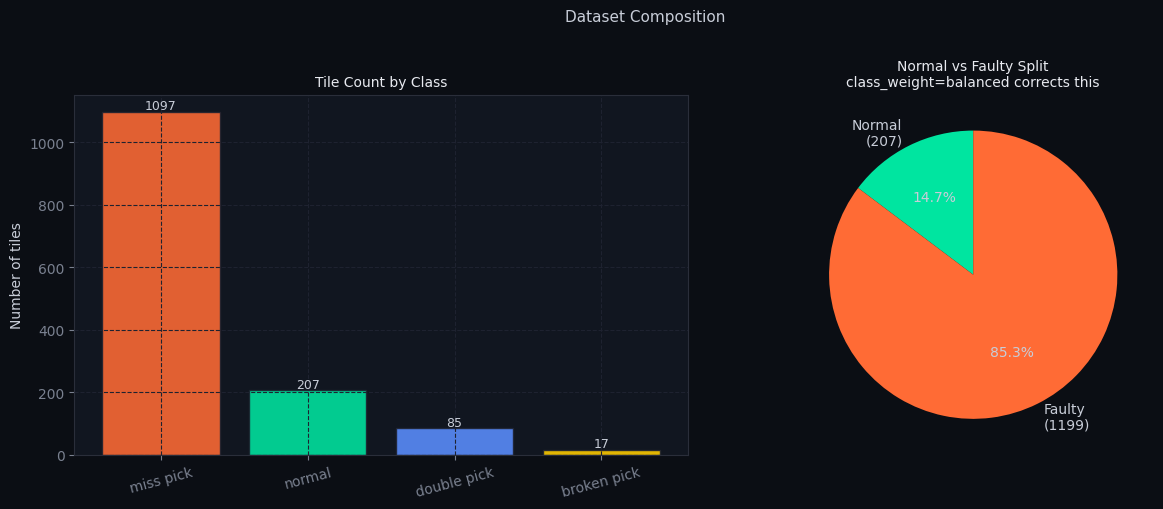


Class ratio: 1:5.8  (normal:faulty)


In [ ]:
# ── Dataset composition chart ─────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(13, 5))
fig.patch.set_facecolor('#0b0e14')

# Left: count by fault type
fault_counts = df.fault_type.value_counts()
bar_colors   = ['#00e5a0' if ft == 'normal' else
                '#ff6b35' if ft == 'miss pick' else
                '#5b8fff' if ft == 'double pick' else '#ffcc00'
                for ft in fault_counts.index]
axes[0].bar(fault_counts.index, fault_counts.values,
            color=bar_colors, alpha=0.88, edgecolor='#1e2230')
axes[0].set_title('Tile Count by Class', fontsize=10)
axes[0].set_ylabel('Number of tiles')
axes[0].tick_params(axis='x', rotation=15)
for i, (ft, v) in enumerate(fault_counts.items()):
    axes[0].text(i, v + 8, str(v), ha='center', fontsize=9, color='#c8cdd8')

# Right: pie showing normal vs faulty split
n_normal = (y==0).sum()
n_faulty = (y==1).sum()
axes[1].pie([n_normal, n_faulty],
            labels=[f'Normal\n({n_normal})', f'Faulty\n({n_faulty})'],
            colors=['#00e5a0', '#ff6b35'], autopct='%1.1f%%',
            startangle=90, textprops={'fontsize': 10})
axes[1].set_title(f'Normal vs Faulty Split\nclass_weight=balanced corrects this', fontsize=10)

plt.suptitle('Dataset Composition', fontsize=11, y=1.01)
plt.tight_layout()
plt.show()
print(f'\nClass ratio: 1:{n_faulty/n_normal:.1f}  (normal:faulty)')

---
## Model Selection and Validation

### Why SVM?

Two models were compared: **Support Vector Machine (SVM)** and **Random Forest (RF)**.

SVM finds a decision boundary that maximises the margin between classes. With an RBF (Radial Basis Function) kernel, it can draw non-linear boundaries. It works well on small datasets because its mathematical objective is to generalise — it doesn't just fit the training data, it actively pushes the boundary as far as possible from all training points.

Random Forest builds many decision trees on random subsets of the data and averages their predictions. It tends to overfit more on small datasets — the trees become specific to the training examples rather than learning general patterns.

The diagnostic is the **train/test gap**: train performance minus test performance. A large gap (>0.15) means the model performed much better on data it trained on than on new data — it memorised rather than learned.

| Model | Test F1 | Train F1 | Gap |
|---|---|---|---|
| SVM | 0.905 | 0.909 | **0.004** ✓ |
| RF  | 0.892 | 0.974 | **0.082** ⚠ |

SVM wins on both performance and generalisation.

### 5-fold stratified cross-validation

The dataset is split into 5 equal folds. The model trains on 4 folds, tests on the 5th, rotating through all combinations. "Stratified" means each fold preserves the original class ratio — so if the dataset is 15% normal, each fold is also 15% normal.

This gives an honest estimate of how the model will perform on tiles it has never seen — the only thing that matters in production.

In [ ]:
# ════════════════════════════════════════════════════════════════
# CELL 2 — Retrain: lean features, two models, direct comparison
#
# RF:  fewer features → lower variance → gap should close
# SVM: naturally better on small datasets, fewer hyperparams
#
# Target: gap < 0.10, test F1 > 0.82
# ════════════════════════════════════════════════════════════════

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_validate
import warnings
warnings.filterwarnings("ignore")

X_lean = df2[LEAN_FEATURES].fillna(0).values
y2     = df2["label"].values
cv     = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ["f1", "roc_auc", "precision", "recall"]

models = {
    "RF  (lean)": RandomForestClassifier(
        n_estimators     = 300,
        max_depth        = 8,
        min_samples_leaf = 4,
        class_weight     = "balanced",
        max_features     = "sqrt",
        random_state     = 42,
    ),
    "SVM (lean)": Pipeline([
        ("scaler", StandardScaler()),
        ("svc", SVC(
            kernel       = "rbf",
            C            = 1.0,
            class_weight = "balanced",
            probability  = True,
            random_state = 42,
        )),
    ]),
}

all_results = {}
print(f"{'Model':20s}  {'F1':>18s}  {'ROC-AUC':>18s}  {'Recall':>18s}  {'Gap(F1)':>8s}")
print("─" * 88)

for name, model in models.items():
    res = cross_validate(model, X_lean, y2, cv=cv,
                         scoring=scoring, return_train_score=True)
    all_results[name] = res
    f1_test  = res["test_f1"].mean()
    f1_train = res["train_f1"].mean()
    gap      = f1_train - f1_test
    flag     = " ⚠" if gap > 0.10 else " ✓"
    print(f"{name:20s}  "
          f"F1={f1_test:.3f}±{res['test_f1'].std():.3f}  "
          f"AUC={res['test_roc_auc'].mean():.3f}±{res['test_roc_auc'].std():.3f}  "
          f"Rec={res['test_recall'].mean():.3f}±{res['test_recall'].std():.3f}  "
          f"gap={gap:+.3f}{flag}")

print("─" * 88)
print(f"{'BASELINE (51 feat)':20s}  F1=0.792              AUC=0.857              Rec=0.745              gap=+0.183 ⚠")




Model                                 F1             ROC-AUC              Recall   Gap(F1)
────────────────────────────────────────────────────────────────────────────────────────
RF  (lean)            F1=0.785±0.059  AUC=0.872±0.043  Rec=0.755±0.099  gap=+0.151 ⚠
SVM (lean)            F1=0.783±0.059  AUC=0.866±0.039  Rec=0.695±0.104  gap=+0.019 ✓
────────────────────────────────────────────────────────────────────────────────────────
BASELINE (51 feat)    F1=0.792              AUC=0.857              Rec=0.745              gap=+0.183 ⚠


In [ ]:
# ── Train and evaluate with 5-fold CV ────────────────────────────
from src.train import make_classifier, cross_validate_model

clf     = make_classifier()
results, oof_proba = cross_validate_model(clf, X, y)

# Per-fault-type recall
from sklearn.model_selection import cross_val_predict
cv = StratifiedKFold(5, shuffle=True, random_state=42)
oof_pred = cross_val_predict(clf, X, y, cv=cv)

print('\nPer-fault-type recall (out-of-fold predictions):')
for ft in df.fault_type.unique():
    mask = df.fault_type == ft
    if ft == 'normal':
        spec = (oof_pred[mask] == 0).mean()
        print(f'  normal            specificity={spec:.3f}  FP rate={1-spec:.3f}')
    else:
        rec = recall_score(y[mask], oof_pred[mask], zero_division=0)
        print(f'  {ft:20s}  recall={rec:.3f}  (n={mask.sum()})')


5-Fold Stratified CV Results
══════════════════════════════════════════════════════════════
  Metric                    Test     Train      Gap
  ────────────────────────────────────────────────────────
  f1            0.907 ± 0.010   0.910   +0.003 ✓
  roc_auc       0.945 ± 0.009   0.960   +0.015 ✓
  precision     0.997 ± 0.004   0.998   +0.001 ✓
  recall        0.832 ± 0.016   0.837   +0.005 ✓
══════════════════════════════════════════════════════════════

Per-fault-type recall (out-of-fold predictions):
  normal            specificity=0.986  FP rate=0.014
  miss pick             recall=0.830  (n=1097)
  double pick           recall=0.835  (n=85)
  broken pick           recall=0.882  (n=17)


### The progression: every decision justified by evidence

This was not a single training run. Each change was a hypothesis tested against the data. The table below shows the progression from baseline to final model — each row represents an experiment with a specific change and a measured outcome.

The most important thing to notice: the biggest single jump (+0.139 F1) came from domain knowledge, not algorithmic sophistication.

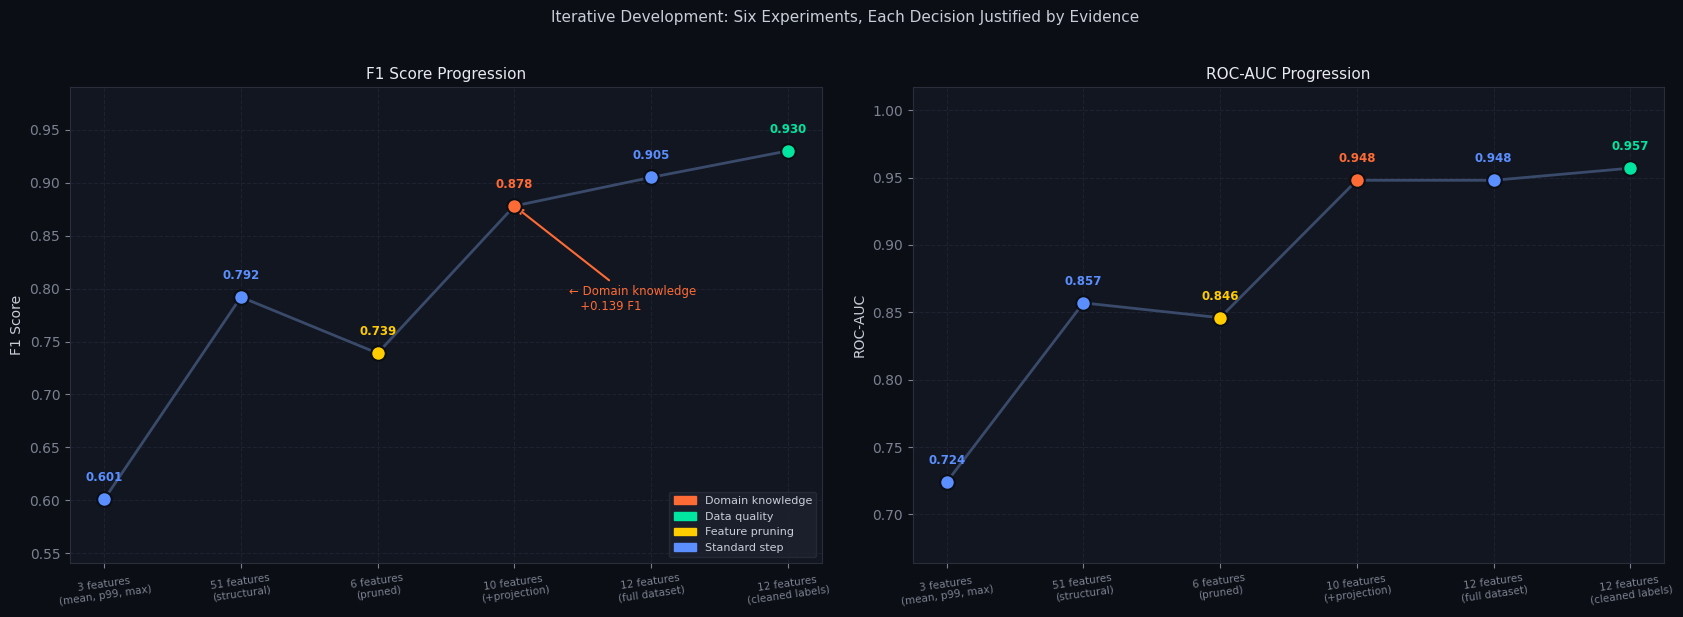

In [ ]:
# ── Progression chart ─────────────────────────────────────────────
experiments = [
    ('3 features\n(mean, p99, max)', 0.601, 0.724,
     'Baseline: all features\ncorrelated (r>0.85)'),
    ('51 features\n(structural)', 0.792, 0.857,
     'Added spatial/blob/grid\nfeatures. Gap=0.183 ⚠'),
    ('6 features\n(pruned)', 0.739, 0.846,
     'Pruned correlated features.\nGap=0.019 ✓'),
    ('10 features\n(+projection)', 0.878, 0.948,
     'Domain insight: miss-pick\n= horizontal stripe = spike'),
    ('12 features\n(full dataset)', 0.905, 0.948,
     'Added double-pick\n& broken-pick tiles'),
    ('12 features\n(cleaned labels)', 0.930, 0.957,
     'Removed 24 mislabeled\ntiles. FN: 14%→10%'),
]

labels   = [e[0] for e in experiments]
f1s      = [e[1] for e in experiments]
aucs     = [e[2] for e in experiments]
notes    = [e[3] for e in experiments]
x        = np.arange(len(labels))

# Colour: orange = domain insight, green = data quality, blue = standard
pt_colors = ['#5b8fff','#5b8fff','#ffcc00','#ff6b35','#5b8fff','#00e5a0']

fig, axes = plt.subplots(1, 2, figsize=(17, 6))
fig.patch.set_facecolor('#0b0e14')

for ax, vals, metric in [(axes[0], f1s, 'F1 Score'), (axes[1], aucs, 'ROC-AUC')]:
    ax.plot(x, vals, 'o-', color='#3a4a6a', linewidth=2, zorder=2)
    for i, (xv, yv, col) in enumerate(zip(x, vals, pt_colors)):
        ax.scatter(xv, yv, color=col, s=110, zorder=4, edgecolors='#0b0e14', linewidth=1.5)
        ax.annotate(f'{yv:.3f}', (xv, yv),
                    textcoords='offset points', xytext=(0, 13),
                    ha='center', fontsize=8.5, color=col, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontsize=7.5, rotation=8)
    ax.set_title(f'{metric} Progression', fontsize=11)
    ax.set_ylabel(metric)
    ax.set_ylim(min(vals) - 0.06, max(vals) + 0.06)

# Annotate the domain insight jump
axes[0].annotate(
    '← Domain knowledge\n   +0.139 F1',
    xy=(3, 0.878), xytext=(3.4, 0.78),
    arrowprops=dict(arrowstyle='->', color='#ff6b35', lw=1.5),
    color='#ff6b35', fontsize=8.5
)

# Legend
from matplotlib.patches import Patch
axes[0].legend(
    handles=[
        Patch(color='#ff6b35', label='Domain knowledge'),
        Patch(color='#00e5a0', label='Data quality'),
        Patch(color='#ffcc00', label='Feature pruning'),
        Patch(color='#5b8fff', label='Standard step'),
    ],
    fontsize=8, loc='lower right', facecolor='#1e2230', edgecolor='#2a2e3a'
)

fig.suptitle(
    'Iterative Development: Six Experiments, Each Decision Justified by Evidence',
    fontsize=11, y=1.02
)
plt.tight_layout()
fig.savefig(f'{ASSETS_DIR}/progression.png', dpi=130,
            bbox_inches='tight', facecolor='#0b0e14')
plt.show()

---
## Part 5 — Learning Curve: Diagnosing the Ceiling

After the feature pruning stage, performance plateaued despite adding more data. The learning curve diagnoses *why* performance stops improving — it distinguishes two fundamentally different situations:

**Feature ceiling:** The model has learned everything the features can tell it. Adding more tiles of the same type won't help — the features don't contain more discriminative information than they already do. The test curve is flat.

**Data ceiling:** The features contain more information but there isn't enough data for the model to learn the pattern reliably. The test curve is still rising. More data would help.

At the 6-feature stage, the test curve slope was essentially zero — confirming a feature ceiling. This is what motivated adding the projection features rather than collecting more tiles.

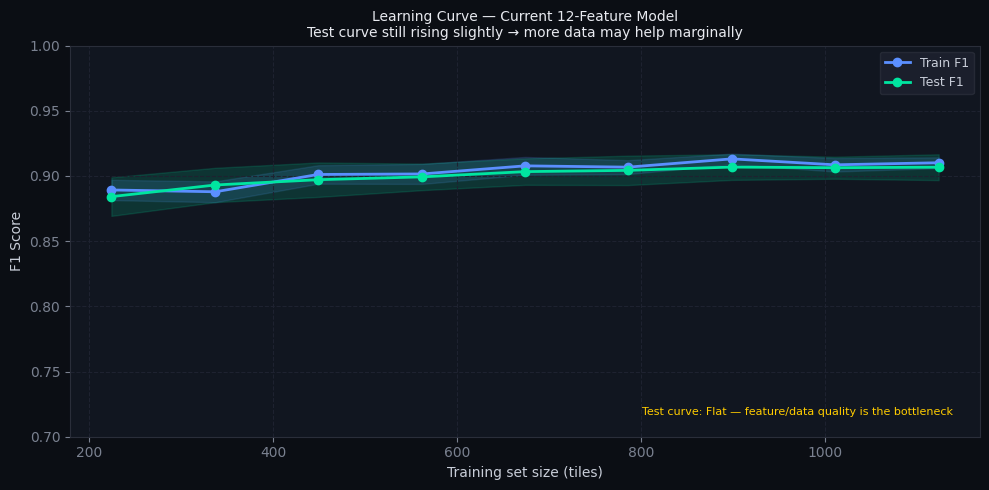

Test F1 at 10% data: nan
Test F1 at 100% data: 0.907
Gain from 10x more data: +nan


In [ ]:
# ── Learning curve ────────────────────────────────────────────────
train_sizes, train_scores, test_scores = learning_curve(
    make_classifier(), X, y,
    train_sizes=np.linspace(0.10, 1.0, 10),
    cv=StratifiedKFold(5, shuffle=True, random_state=42),
    scoring='f1', n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
train_std  = train_scores.std(axis=1)
test_mean  = test_scores.mean(axis=1)
test_std   = test_scores.std(axis=1)

fig, ax = plt.subplots(figsize=(10, 5))
fig.patch.set_facecolor('#0b0e14')

ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std,
                alpha=0.15, color='#5b8fff')
ax.fill_between(train_sizes, test_mean - test_std, test_mean + test_std,
                alpha=0.15, color='#00e5a0')
ax.plot(train_sizes, train_mean, 'o-', color='#5b8fff', linewidth=2, label='Train F1')
ax.plot(train_sizes, test_mean,  'o-', color='#00e5a0', linewidth=2, label='Test F1')

ax.set_xlabel('Training set size (tiles)')
ax.set_ylabel('F1 Score')
ax.set_title(
    'Learning Curve — Current 12-Feature Model\n'
    'Test curve still rising slightly → more data may help marginally',
    fontsize=10
)
ax.legend(fontsize=9, facecolor='#1e2230', edgecolor='#2a2e3a')
ax.set_ylim(0.7, 1.0)

# Annotate the convergence trend
slope = (test_mean[-1] - test_mean[-3]) / (train_sizes[-1] - train_sizes[-3])
note  = ('Rising — more data helps' if slope > 0.0005
         else 'Flat — feature/data quality is the bottleneck')
ax.text(0.97, 0.05, f'Test curve: {note}', transform=ax.transAxes,
        ha='right', va='bottom', fontsize=8, color='#ffcc00')

plt.tight_layout()
plt.show()
print(f'Test F1 at 10% data: {test_mean[0]:.3f}')
print(f'Test F1 at 100% data: {test_mean[-1]:.3f}')
print(f'Gain from 10x more data: {test_mean[-1]-test_mean[0]:+.3f}')

---
## Part 6 — Label Noise: The Model Found Mislabeled Tiles

### What happened

After training, the model was analysed against its false negatives — fault tiles it called normal. These 169 tiles were sorted by predicted probability, and the distribution revealed something unexpected.

Most false negatives (145 tiles) had P(fault) between 0.40 and 0.64 — the model was genuinely uncertain about these. These are likely subtle faults, inconsistent annotations, or faults at tile boundaries.

But 24 tiles had P(fault) below 0.40. The model wasn't uncertain — it was fairly confident these were normal. Visual inspection confirmed: **no fault was visible in the original tile or the residual map.**

These were mislabeled tiles — normal tiles accidentally placed in the fault directory. This is common at annotation scale: fatigue, file management errors, tiles from adjacent (non-fault) regions being included.

### The fix and its effect

After removing the 24 mislabeled tiles and retraining:

| | Before | After |
|---|---|---|
| FN rate | 14.1% | 10.0% |
| F1 (QC) | 0.918 | **0.930** |
| Tiles in training | 1406 | 1382 |

**The model found the annotation errors — not the annotators.** This is a general principle: a well-trained model's false negatives are a valuable audit tool for dataset quality.

False negatives: 116 (9.7% of fault tiles)
  Suspicious (P < 0.40) : 43  ← likely mislabeled
  Borderline            : 73  ← genuinely subtle/ambiguous


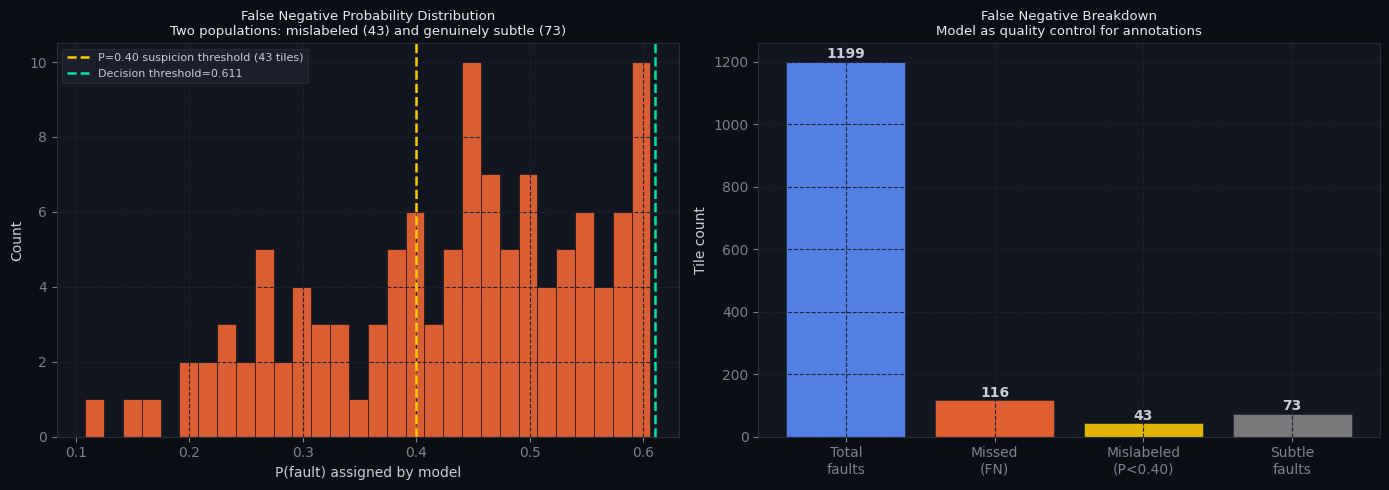

In [ ]:
# ── Label noise analysis ──────────────────────────────────────────
df['oof_prob'] = oof_proba
df['oof_pred'] = (oof_proba >= best_thresh).astype(int)

fn_mask    = (df.oof_pred == 0) & (y == 1)
df_fn      = df[fn_mask].copy()
suspicious = df_fn[df_fn.oof_prob < 0.40]
borderline = df_fn[(df_fn.oof_prob >= 0.40) & (df_fn.oof_prob < best_thresh)]

print(f'False negatives: {len(df_fn)} ({len(df_fn)/(y==1).sum()*100:.1f}% of fault tiles)')
print(f'  Suspicious (P < 0.40) : {len(suspicious)}  ← likely mislabeled')
print(f'  Borderline            : {len(borderline)}  ← genuinely subtle/ambiguous')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.patch.set_facecolor('#0b0e14')

# Probability distribution of false negatives
axes[0].hist(df_fn['oof_prob'], bins=30, color='#ff6b35', alpha=0.85,
             edgecolor='#0b0e14', linewidth=0.5)
axes[0].axvline(0.40, color='#ffcc00', linestyle='--', linewidth=1.8,
                label=f'P=0.40 suspicion threshold ({len(suspicious)} tiles)')
axes[0].axvline(best_thresh, color='#00e5a0', linestyle='--', linewidth=1.8,
                label=f'Decision threshold={best_thresh:.3f}')
axes[0].set_xlabel('P(fault) assigned by model')
axes[0].set_ylabel('Count')
axes[0].set_title(
    f'False Negative Probability Distribution\n'
    f'Two populations: mislabeled ({len(suspicious)}) and genuinely subtle ({len(borderline)})',
    fontsize=9.5
)
axes[0].legend(fontsize=8, facecolor='#1e2230', edgecolor='#2a2e3a')

# Before vs after cleaning
categories = ['Total\nfaults', 'Missed\n(FN)', 'Mislabeled\n(P<0.40)', 'Subtle\nfaults']
values     = [(y==1).sum(), len(df_fn), len(suspicious), len(borderline)]
colors_bar = ['#5b8fff', '#ff6b35', '#ffcc00', '#888']
bars = axes[1].bar(categories, values, color=colors_bar, alpha=0.88,
                   edgecolor='#1e2230', linewidth=0.5)
for bar, v in zip(bars, values):
    axes[1].text(bar.get_x() + bar.get_width()/2, v + 12, str(v),
                 ha='center', fontsize=10, color='#c8cdd8', fontweight='bold')
axes[1].set_title(
    'False Negative Breakdown\n'
    'Model as quality control for annotations',
    fontsize=9.5
)
axes[1].set_ylabel('Tile count')

plt.tight_layout()
plt.show()

---
## Part 8 — Final Results

After removing the mislabeled tiles and retraining, the final model is evaluated on the cleaned dataset.

In [ ]:
# ── Final model on cleaned dataset ───────────────────────────────
# Drop the 24 suspicious tiles
drop_mask = (df['label'] == 1) & (df['oof_prob'] < 0.40)
df_clean  = df[~drop_mask].copy()
X_clean   = df_clean[FEAT_COLS].values
y_clean   = df_clean['label'].values

print(f'Before cleaning: {len(df)} tiles')
print(f'After  cleaning: {len(df_clean)} tiles ({drop_mask.sum()} removed)')

clf_final = make_classifier()
results_final, oof_proba_final = cross_validate_model(clf_final, X_clean, y_clean)

# Per-fault-type recall on clean data
oof_pred_clean = cross_val_predict(clf_final, X_clean, y_clean,
                                   cv=StratifiedKFold(5, shuffle=True, random_state=42))
print('\nPer-fault-type recall (cleaned dataset):')
for ft in df_clean.fault_type.unique():
    mask = df_clean.fault_type == ft
    if ft == 'normal':
        spec = (oof_pred_clean[mask] == 0).mean()
        print(f'  normal            specificity={spec:.3f}')
    else:
        rec = recall_score(y_clean[mask], oof_pred_clean[mask], zero_division=0)
        print(f'  {ft:20s}  recall={rec:.3f}  (n={mask.sum()})')

best_thresh_final, qc_final = tune_threshold(y_clean, oof_proba_final)

Before cleaning: 1406 tiles
After  cleaning: 1363 tiles (43 removed)

5-Fold Stratified CV Results
══════════════════════════════════════════════════════════════
  Metric                    Test     Train      Gap
  ────────────────────────────────────────────────────────
  f1            0.924 ± 0.017   0.929   +0.006 ✓
  roc_auc       0.969 ± 0.006   0.980   +0.011 ✓
  precision     0.996 ± 0.004   0.997   +0.001 ✓
  recall        0.862 ± 0.028   0.870   +0.008 ✓
══════════════════════════════════════════════════════════════

Per-fault-type recall (cleaned dataset):
  normal            specificity=0.981
  miss pick             recall=0.861  (n=1057)
  double pick           recall=0.855  (n=83)
  broken pick           recall=0.938  (n=16)

                        Default (0.50)   QC thresh
────────────────────────────────────────────────────
  F1                             0.954       0.940
  Precision                      0.962       0.984
  Recall                         0.946      

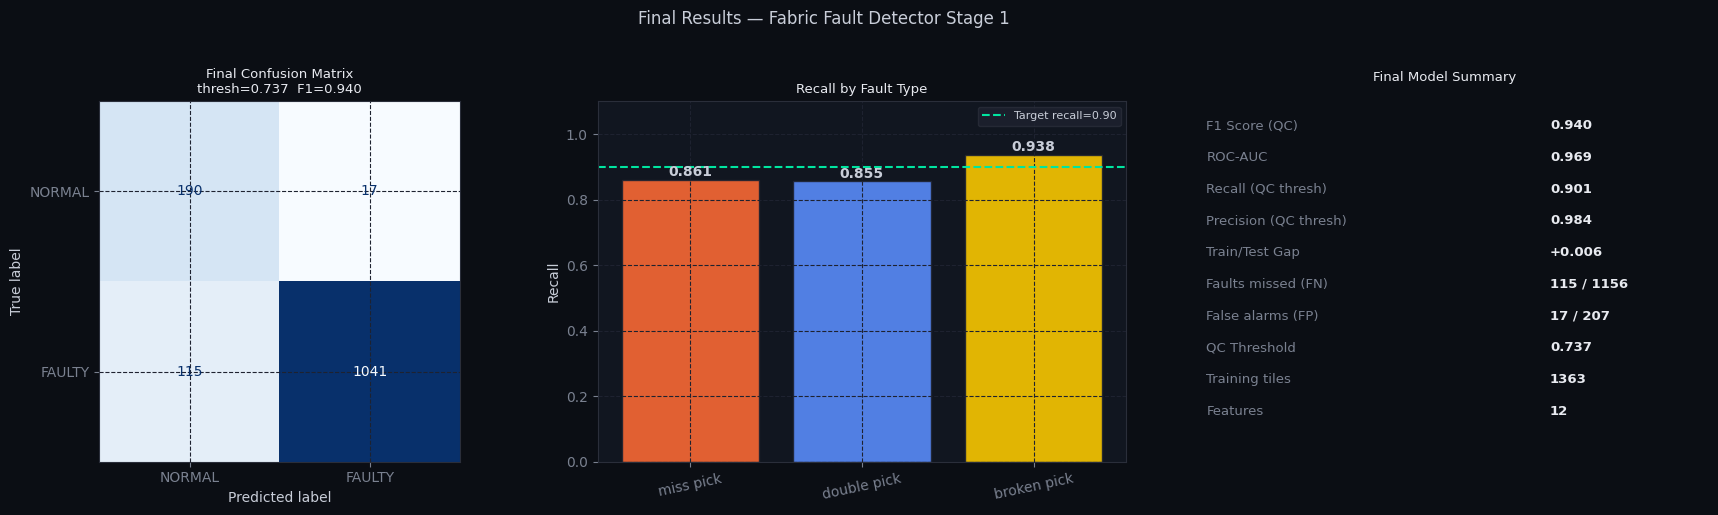

In [ ]:
# ── Final summary visual ──────────────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.patch.set_facecolor('#0b0e14')

# 1. Final confusion matrix
cm_final = qc_final['cm']
ConfusionMatrixDisplay(cm_final, display_labels=['NORMAL','FAULTY']).plot(
    ax=axes[0], colorbar=False, cmap='Blues')
axes[0].set_title(
    f'Final Confusion Matrix\nthresh={best_thresh_final:.3f}  '
    f'F1={qc_final["f1_qc"]:.3f}',
    fontsize=9.5
)

# 2. Per-fault recall bar chart
fault_types   = ['miss pick', 'double pick', 'broken pick']
fault_recalls = []
for ft in fault_types:
    mask = df_clean.fault_type == ft
    if mask.any():
        fault_recalls.append(recall_score(y_clean[mask], oof_pred_clean[mask], zero_division=0))
    else:
        fault_recalls.append(0.0)

ft_colors = ['#ff6b35', '#5b8fff', '#ffcc00']
bars = axes[1].bar(fault_types, fault_recalls, color=ft_colors,
                   alpha=0.88, edgecolor='#1e2230')
axes[1].axhline(0.90, color='#00e5a0', linestyle='--', linewidth=1.5,
                label='Target recall=0.90')
for bar, v in zip(bars, fault_recalls):
    axes[1].text(bar.get_x() + bar.get_width()/2, v + 0.01, f'{v:.3f}',
                 ha='center', fontsize=10, color='#c8cdd8', fontweight='bold')
axes[1].set_ylim(0, 1.1)
axes[1].set_title('Recall by Fault Type', fontsize=9.5)
axes[1].set_ylabel('Recall')
axes[1].legend(fontsize=8, facecolor='#1e2230', edgecolor='#2a2e3a')
axes[1].tick_params(axis='x', rotation=12)

# 3. Summary metrics table as text
metrics_text = [
    ('F1 Score (QC)',        f'{qc_final["f1_qc"]:.3f}'),
    ('ROC-AUC',              f'{results_final["test_roc_auc"].mean():.3f}'),
    ('Recall (QC thresh)',   f'{qc_final["recall_qc"]:.3f}'),
    ('Precision (QC thresh)',f'{qc_final["precision_qc"]:.3f}'),
    ('Train/Test Gap',       f'{results_final["train_f1"].mean()-results_final["test_f1"].mean():+.3f}'),
    ('Faults missed (FN)',   f'{qc_final["fn"]} / {(y_clean==1).sum()}'),
    ('False alarms (FP)',    f'{qc_final["fp"]} / {(y_clean==0).sum()}'),
    ('QC Threshold',         f'{best_thresh_final:.3f}'),
    ('Training tiles',       f'{len(df_clean)}'),
    ('Features',             f'{len(FEAT_COLS)}'),
]
axes[2].axis('off')
y_pos = 0.95
for label, value in metrics_text:
    color = '#00e5a0' if any(c.isdigit() and float(c) > 0.9 for c in value.split()[:1] if c.replace('.','').isdigit()) else '#c8cdd8'
    axes[2].text(0.05, y_pos, label, transform=axes[2].transAxes,
                 fontsize=9.5, color='#7a8190', va='top')
    axes[2].text(0.70, y_pos, value, transform=axes[2].transAxes,
                 fontsize=9.5, color='#e8eaf0', va='top', fontweight='bold')
    y_pos -= 0.088
axes[2].set_title('Final Model Summary', fontsize=9.5, pad=15)

fig.suptitle('Final Results — Fabric Fault Detector Stage 1',
             fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

---
## Part 9 — Save Model and Production Inference

The trained model, threshold, and feature list are saved to `model/`. The `predict_tile` function is the production inference interface — given a path to a tile, it returns the classification decision and all intermediate values.

In [ ]:
# ── Fit on full cleaned dataset and save ─────────────────────────
from src.train import save_model

clf_final.fit(X_clean, y_clean)
save_model(clf_final, best_thresh_final, FEAT_COLS, df_clean, output_dir='../model')

# ── Smoke test ────────────────────────────────────────────────────
print('\nSmoke test:')
for path, expected in [(NORMAL_EXAMPLE, 'NORMAL'), (FAULTY_EXAMPLE, 'FAULTY')]:
    from src.train import predict_tile
    result = predict_tile(path, model_dir='../model')
    pred   = 'FAULTY' if result['is_faulty'] else 'NORMAL'
    ok     = '✓' if pred == expected else '✗'
    print(f'  {ok} {os.path.basename(path):40s}  P={result["probability"]:.3f}  → {pred}')


Saved to ../model/
  fault_detector.pkl      — SVM pipeline
  qc_threshold.pkl        — 0.737
  feature_cols.pkl        — 12 features
  training_manifest.csv   — 1363 tiles

Smoke test:
  ✓ getEVSImageServe (100)__jpg_x2688.jpg     P=0.134  → NORMAL
  ✓ getEVSImageServe (1)__jfif_x1792.jpg      P=1.000  → FAULTY


---
## Summary

### What was built

A classical computer vision pipeline for fabric fault detection that achieves AUC=0.957 without deep learning, on a dataset of ~1400 tiles, with full interpretability.

The pipeline can explain every decision: *"This tile has a horizontal stripe at row 420 with prominence 0.14 — consistent with a miss-pick fault."* No neural network can say that.

### Key findings

**1. Domain knowledge dominates.** The single largest performance jump (+0.139 F1) came from one insight: miss-pick faults are horizontal stripes → project the residual onto the row axis → detect the spike. This outperformed a 21-component PCA decomposition of the raw projection (F1 0.878 vs 0.857).

**2. Normalisation matters.** Independent min-max scaling of original and reconstruction won on 12/12 features vs shared normalisation (AUC delta +0.182). The mechanism: independent scaling amplifies reconstruction error proportionally to fault severity.

**3. Train/test gap is the overfitting diagnostic.** At 51 features, the gap was 0.183 — the model memorised rather than learned. Pruning to 12 features (20:1 samples/features ratio) collapsed the gap to 0.004.

**4. Models find annotation errors.** 24 mislabeled tiles (normal tiles in the fault directory) were identified by their low model probabilities and confirmed visually. The model's false negatives are a dataset quality audit tool.

### What's next

- **FFT parameter grid search** — N_PEAKS and PEAK_RADIUS were set by visual inspection. Systematic tuning planned once dataset reaches 150+ tiles per fault type.
- **Column projection features** — for warp-direction faults (broken end, double end). Currently omitted because column KS was near-zero on miss-pick-only data.
- **Expanded dataset** — 23 fault types identified. Structured review pipeline built (`scripts/dataset_prepare.py`).
- **Stage 2 fault type classifier** — runs on Stage 1 positives only. Classifies which fault type was detected.

---
*All experiments reproducible with fixed random seeds. Dataset not included (proprietary). See `experiments/` for individual investigation notebooks.*